In [104]:
import torch
from torch import cuda, device, distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym
import os, random

from collections import deque

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from IPython.display import clear_output

In [105]:
env_id = "CartPole-v1"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print(f'The State Space is {s_size}')
print(f'The Action Space is {a_size}')
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is 4
The Action Space is 2
Sample observation [-4.0260787e+00 -2.7828089e+38  2.5189364e-01 -5.0994486e+37]


In [106]:
device = device("cuda:0" if cuda.is_available() else "cpu")

In [107]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc_pi = nn.Linear(128, action_dim)
        self.fc_v = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        pi = torch.softmax(self.fc_pi(x), dim=-1)
        v = self.fc_v(x)
        
        return pi, v

class Agent():
    def __init__(self, state_size, action_size, hidden_size, gamma = 0.99, learning_rate = 0.001):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.gamma = gamma
        
        self.ac = ActorCritic(s_size, a_size).to(device)
        self.optimizer = optim.Adam(self.ac.parameters(), lr = learning_rate)
    
    def save(self, model_file):
        torch.save(self.ac.state_dict(), model_file)
        
    def load(self, model_file):
        self.ac.load_state_dict(torch.load(model_file))

In [108]:
hidden_layer = 64
gamma = 0.99
episodes = 100_000
avg_win_size = 50
epi_results = deque(maxlen=avg_win_size)

agent = Agent(s_size, a_size, hidden_layer,  gamma = gamma)

In [109]:
log_file_name = os.path.join('.','artefacts',f'{env_id}_actorcritic.csv')
model_file = os.path.join('.','models',f'{env_id}_actorcritic.pt')

In [110]:
train = False

if train:
    log_file = open(log_file_name, "w")
    log_file.write(f'episode,loss,rewards\n')

for epi in range(episodes):

    s, _ = env.reset()
    done, trunc  = False, False
    rewards = 0
    
    while not done:

        if not train:
            print("set train flag to True for Training")
            break

        obs = torch.FloatTensor(s).to(device)

        #with torch.no_grad():
        probs, val = agent.ac(obs)
        p_vals = probs.detach().cpu().numpy()
        
        a = np.random.choice(a_size, p=p_vals)
        s_, r, done ,trunc , _  = env.step(a)
        rewards += r
        
        if rewards >500:
            done = True
        
        # Update Step     
        obs_ = torch.FloatTensor(s_).to(device)
        _, nxt_val = agent.ac(obs_)
        err = r + gamma * (nxt_val * (1 - int(done))) - val
        
        actor_loss = -torch.log(probs[a]) * err
        critic_loss = torch.square(err)
        loss = actor_loss + critic_loss
        
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step()
        # 
        s=np.copy(s_)

    epi_results.append(rewards)
    log_file.write(f'{epi},{loss.item():.2f},{rewards:5.0f}\n')
    
    if epi%100==0:
        clear_output()
    if epi%10==0:
        print(f'Episode {epi:05d}: Episode reward = {rewards:5.0f} Avg reward = {np.mean(epi_results):5.2f}')
    if np.mean(np.mean(epi_results))>500:
        break


if train:
    print(f'Saving Agent as {model_file}')
    agent.save(model_file)
    log_file.close()

Episode 00600: Episode reward =   501 Avg reward = 458.02
Episode 00610: Episode reward =   501 Avg reward = 461.96
Episode 00620: Episode reward =   501 Avg reward = 462.46
Episode 00630: Episode reward =   501 Avg reward = 462.54
Episode 00640: Episode reward =   501 Avg reward = 475.32
Episode 00650: Episode reward =   501 Avg reward = 499.44
Episode 00660: Episode reward =   501 Avg reward = 499.44
Episode 00670: Episode reward =   501 Avg reward = 499.44
Saving Agent as .\models\CartPole-v1_actorcritic.pt


In [111]:
eval_agent = Agent(s_size, a_size, hidden_layer)
eval_agent.load(model_file)
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

Text(0.5, 1.0, 'Loss')

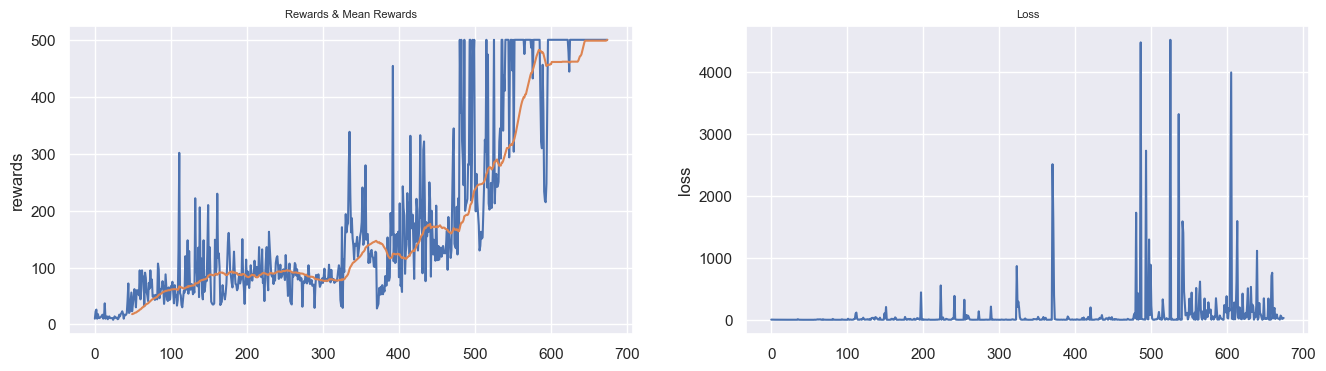

In [112]:
fig,ax=plt.subplots(1,2,sharex='col',sharey= False,figsize=(16,4))

sns.lineplot(df['rewards'], ax = ax[0])
sns.lineplot(df['mean_rewards'],ax = ax[0])
ax[0].set_title('Rewards & Mean Rewards',fontsize=8)

sns.lineplot(df['loss'],ax = ax[1])
ax[1].set_title('Loss',fontsize=8)
#sns.histplot(df['l2_grad'],ax = ax[2], kde = True)
#ax[2].set_title('Gradient',fontsize=8)

In [113]:
env_id = 'CartPole-v1'
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):
    
    s, _ = eval_env.reset()
    done = False
    total_reward = 0
    
    while not done:
        
        obs = torch.FloatTensor(s).to(device)        
        probs, val = eval_agent.ac(obs)
        p_vals = probs.detach().cpu().numpy()
        a = np.random.choice(a_size, p=p_vals)
        
        s_, r, done ,term , _  = eval_env.step(a)
        total_reward += r

        if total_reward >500:
            done = True
        s = s_
    
    print(f'epi{epi} score:{total_reward}')
eval_env.close()

epi0 score:501.0
epi1 score:501.0
epi2 score:501.0
epi3 score:501.0
epi4 score:501.0
epi5 score:501.0
epi6 score:501.0
epi7 score:501.0
epi8 score:501.0
epi9 score:501.0
